<a href="https://colab.research.google.com/github/JuliaKoryukova/Machine-Learning/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='7'>**Аналитика больших данных. Временные ряды. ARIMA, SARIMA**</font>  






<font color='#0066CC' size='3'>В данной работе применяется датасет Потребление электричества electric-production.csv

**Описание плана работы**

1. Загрузка данных.
2. Разведочный анализ данных (EDA).
3. Анализ временного ряда: скользящее окно, сезонная декомпозиция, автокорреляция, частичная автокорреляция
4. Тест на стационарность ряда. Вывод о стационарности.
5. Разделение данных на тестовую и тренировочную выборки.
6. Автоматический подбор параметров для ряда с помощью auto_arima. Выбор оптимальных значений.
7. Построение и обучение модели ARIMA. Прогноз для тестового набора данных. Оценка модели ARIMA.
8. Построение и обучение модели SARIMA. Прогноз для тестового набора данных. Оценка модели SARIMA.
9. Перетренировка лучшей модели на всех данных для прогноза и построение графика.

# <font color='#11a642' size='6'> Импорт и установка библиотек


In [ ]:
# Установка дополнительной библиотеки
!pip install pmdarima

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats  # Статистические методы
from scipy.stats import normaltest # Критерий Д'Агостино K^2, оценка данных на распределение Гаусса
from statsmodels.tsa.seasonal import seasonal_decompose  # Оценка сезонности
from statsmodels.tsa.statespace.tools import diff  # Разность рядов просто и/или сезонно вдоль нулевой оси
from statsmodels.tsa.arima.model import ARIMA  # Построить модель ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Построить модель SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Графики ACF и PACF
from statsmodels.graphics.tsaplots import month_plot # Помесячный график
from pandas.plotting import lag_plot  # График лага
from statsmodels.tsa.stattools import adfuller  # Тест Дики-Фуллера на стационарность

from sklearn.metrics import mean_squared_error  # MSE
from pmdarima import auto_arima  # Автоматический подбор параметров ARIMA

%matplotlib inline

In [ ]:
def adf_test(series,title=''):
  '''
  тест Дики-Фуллера
  0 гипотеза: ряд данных не стационарен
  альтернативная гипотеза: ряд данных стационарен
  Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
  @param series - значения ряда
  @param title - заголовок ряда
  '''

  result = adfuller(series.dropna(),autolag='AIC')

  labels = ['ADF тест','p-value','# lags used','# наблюдения']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'критическое значение ({key})']=val

  print(out.to_string())

  if result[1] <= 0.05:
      print("Сильные доказательства против нулевой гипотезы")
      print("Отменяем 0 гипотезу")
      print("Данные стационарны")
  else:
      print("Слабые доказательства против нулевой гипотезы")
      print("Не отменяем 0 гипотезу")
      print("Данные не стационарны")

# <font color='#11a642' size='6'> Загрузка данных


In [ ]:
!gdown 1NhBUYZrPcaRoOjmZ-LvYzgEkAzfZwCCX

Downloading...
From: https://drive.google.com/uc?id=1NhBUYZrPcaRoOjmZ-LvYzgEkAzfZwCCX
To: /content/electric-production.csv
100% 7.32k/7.32k [00:00<00:00, 18.1MB/s]


In [ ]:
# Чтение и просмотр датасета
df = pd.read_csv('https://drive.google.com/uc?id=1NhBUYZrPcaRoOjmZ-LvYzgEkAzfZwCCX', index_col="DATE", parse_dates= True)
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
# Установка частоты данных
df = df.asfreq('MS')

In [ ]:
# Проверка типов данных
df.dtypes

,0
IPG2211A2N,float64


# <font color='#11a642' size='6'> Разведочный анализ данных (EDA)

## <font color='#11a642' size='5'> Оценка размера датасета





1.   Сколько весит датасет
2.   Сколько строк и столбцов


In [ ]:
# Сколько kБ датасет
size_byte = df.memory_usage(index=True).sum()
size_kb = size_byte / 1024

size_df = size_kb

print(f"The dataset df is {size_df:.2f} kB")

The dataset df is 6.20 kB


In [ ]:
# Сколько строк и столбцов
df.shape

(397, 1)

In [ ]:
len(df)

397

## <font color='#11a642' size='5'> Анализ пропусков и выбросов


In [ ]:
# Основные статистики датасета
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IPG2211A2N,397.0,88.847218,15.387834,55.3151,77.1052,89.7795,100.5244,129.4048


In [ ]:
# Проверка пропусков
df.isna().sum()

,0
IPG2211A2N,0


In [ ]:
# Поиск выбросов
results = {'Столбец': [], 'Выбросы': []}
# Расчет IQR
for column in df:
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  # Определение выбросов
  outliers_iqr_train = df[column][(df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)]

  # Результаты
  results['Столбец'].append(column)
  results['Выбросы'].append(outliers_iqr_train.shape[0])

  # Создаем таблицу
  df_outliers = pd.DataFrame(results)

df_outliers

,Столбец,Выбросы
0,IPG2211A2N,0


# <font color='#11a642' size='6'> Анализ временного ряда

## <font color='#11a642' size='5'>Скользящее окно

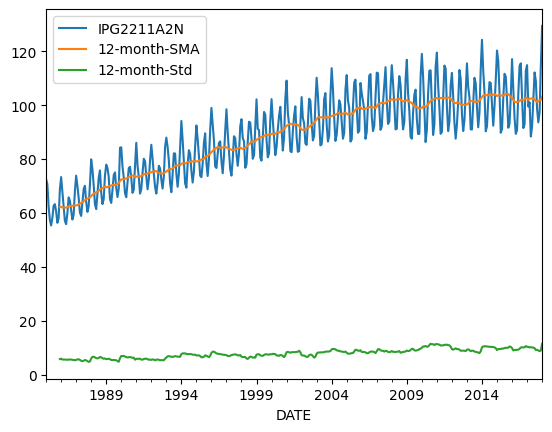

In [ ]:
# Расчеты скользящего окна
df['12-month-SMA'] = df['IPG2211A2N'].rolling(window=12).mean()
df['12-month-Std'] = df['IPG2211A2N'].rolling(window=12).std()

df[['IPG2211A2N','12-month-SMA','12-month-Std']].plot();

## <font color='#11a642' size='5'>Сезонная декомпозиция


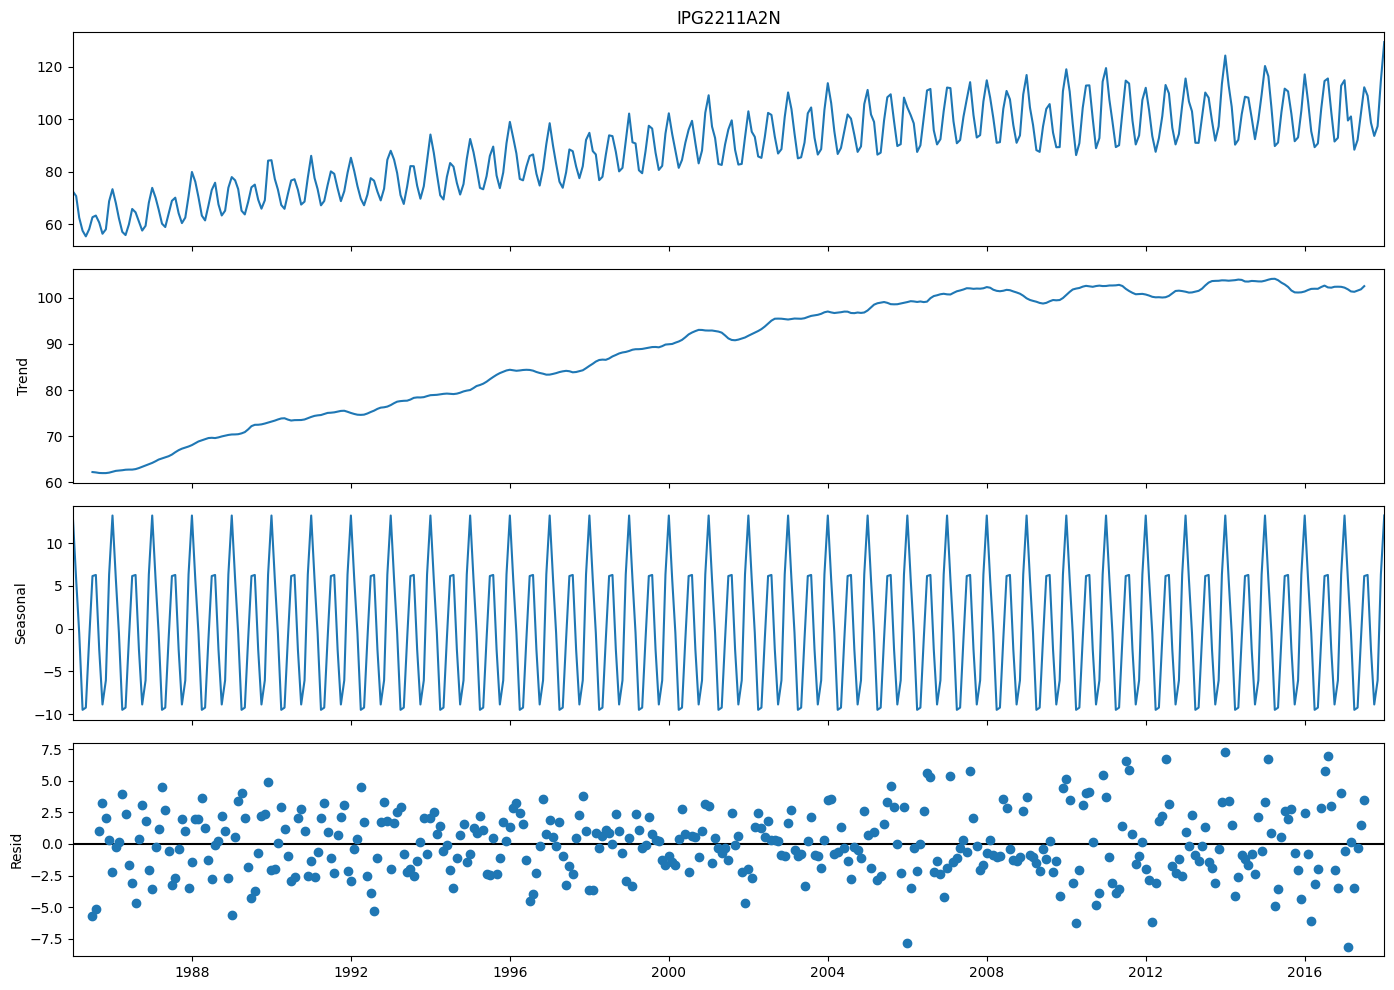

In [ ]:
# Сезонная декомпозиция
ssn= seasonal_decompose(df["IPG2211A2N"], model="add")
fig = ssn.plot()
fig.set_size_inches((14, 10))
fig.tight_layout()
plt.show()

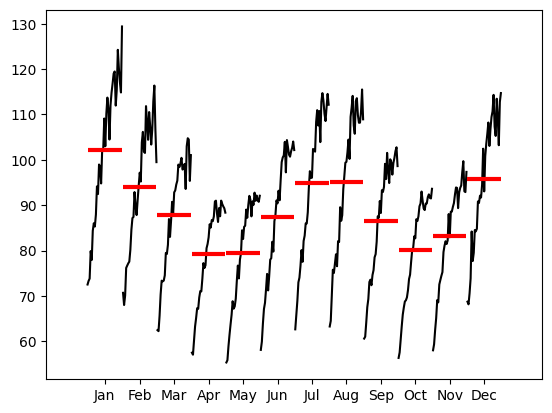

In [ ]:
# Построение помесячного графика
month_plot(df['IPG2211A2N']);

## <font color='#11a642' size='5'>Автокорреляция

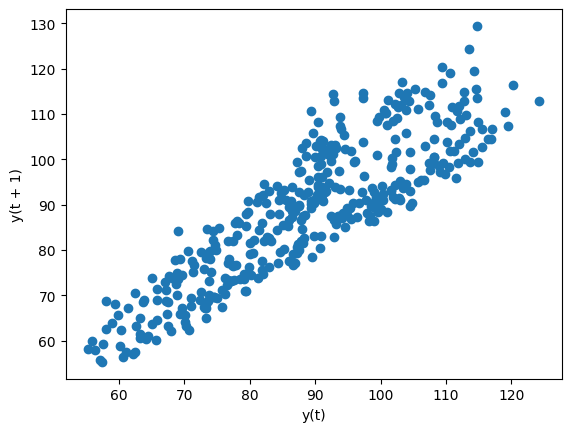

In [ ]:
# автокорреляция значения t+1 (следующий лаг времени) от текущего (t)
# здесь есть строгая корреляция
# Лаговый график
lag_plot(df['IPG2211A2N']);

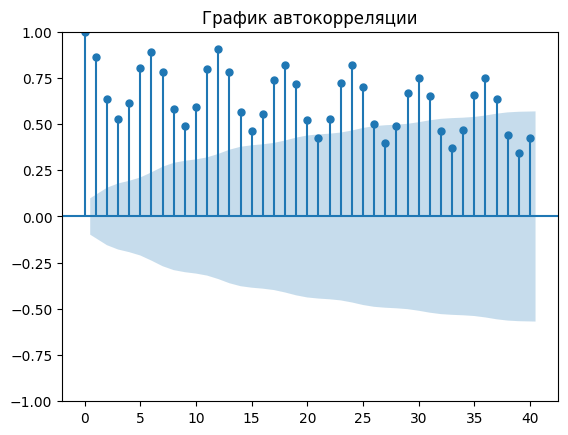

In [ ]:
# ACF
title = 'График автокорреляции'
lags = 40 # оптимальное значение (т.к. большой временной период)
plot_acf(df["IPG2211A2N"],title=title,lags=lags);

## <font color='#11a642' size='5'>Частичная автокорреляция

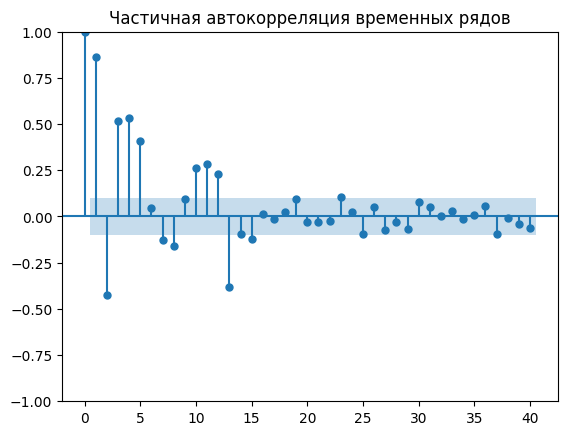

In [ ]:
# PACF - функция частичной автокорреляции дает частичную корреляцию стационарного временного ряда с его собственными запаздывающими значениями
title = 'Частичная автокорреляция временных рядов'
lags = 40
plot_pacf(df["IPG2211A2N"],title=title,lags=lags);

# <font color='#11a642' size='6'> Тест на стационарность ряда

In [ ]:
# Тест на стационарность, p-value < 0.05
adf_test(df["IPG2211A2N"])

ADF тест                       -2.256990
p-value                         0.186215
# lags used                    15.000000
# наблюдения                  381.000000
критическое значение (1%)      -3.447631
критическое значение (5%)      -2.869156
критическое значение (10%)     -2.570827
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


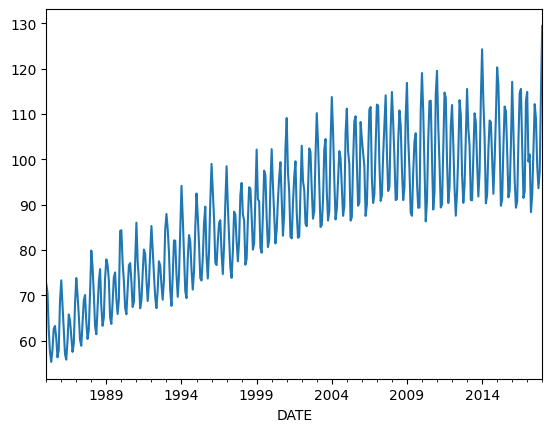

In [ ]:
df["IPG2211A2N"].plot();

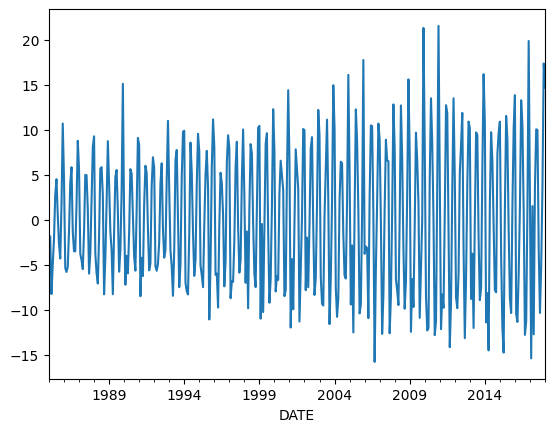

In [ ]:
# Сконвертируем нестационарный ряд в стационарный
# Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
df["difference_1"]= diff(df["IPG2211A2N"], k_diff=1)
df["difference_1"].plot();

In [ ]:
adf_test(df["difference_1"])

ADF тест                     -7.104891e+00
p-value                       4.077787e-10
# lags used                   1.400000e+01
# наблюдения                  3.810000e+02
критическое значение (1%)    -3.447631e+00
критическое значение (5%)    -2.869156e+00
критическое значение (10%)   -2.570827e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


Вывод о стационарности:

Исходный временной ряд не стационарный, имеет тренд и его среднее значение изменяется во времени.

После дифференцирования первого порядка временной ряд стал стационарным, его среднее значение больше не меняется во времени и в нем отсутствует тренд.

# <font color='#11a642' size='6'> Разделение данных на тестовую и тренировочную выборки

In [ ]:
# Разделение на тестовый и тренировочный набор данных
TEST_SIZE = int(len(df) * 0.2)
train= df.iloc[:len(df)-TEST_SIZE]
test= df.iloc[len(df)-TEST_SIZE:]

print(len(train))
print(len(test))

318
79


# <font color='#11a642' size='6'> Автоматический подбор параметров для ряда
Автоматический подбор параметров для ряда с помощью auto_arima. Выбор оптимальных значений

In [ ]:
# Нахождение порядков p,d,q
# ARIMA: обучение модели без сезонной составляющей
auto_arima_results= auto_arima(train["IPG2211A2N"],
           start_p=0,
           start_q=0,
           max_p=3,
           max_q=3,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2161.273, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2116.650, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2059.444, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2159.327, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2061.136, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1971.596, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1987.537, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.423 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  318
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -981.798
Date:                Thu, 12 Sep 2024   AIC                           1971.596
Time:                        11:26:58   BIC                           1986.632
Sample:                    01-01-1985   HQIC                          1977.602
                         - 06-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1339      0.012     11.520      0.000       0.111       0.157
ma.L1         -0.1933      0.036     -5.380      0.000      -0.264      -0.123
ma.L2         -0.7746      0.043    -18.077      0.000      -0.859      -0.691
sigma2        28.4020      2.459     11.548      0.000      23.582      33.222
===================================================================================
Ljung-Box (L1) (Q):                  18.55   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.00   Prob(JB):                         0.41
Heteroskedasticity (H):               2.55   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Вывод (сравнение значений параметров):

p=0: Порядок авторегрессии (AR) равен 0. Это значит, что текущие значения не зависят от прошлых значений ряда.

d=1: Порядок интегрирования (разности) равен 1. Это подтверждает, что для стационарности данных понадобилось одно дифференцирование, что соответствует результатам теста на стационарность.

q=2: Порядок скользящего среднего (MA) равен 2. Это указывает на то, что для учета шума в модели достаточно двух запаздывающих ошибок прогноза.



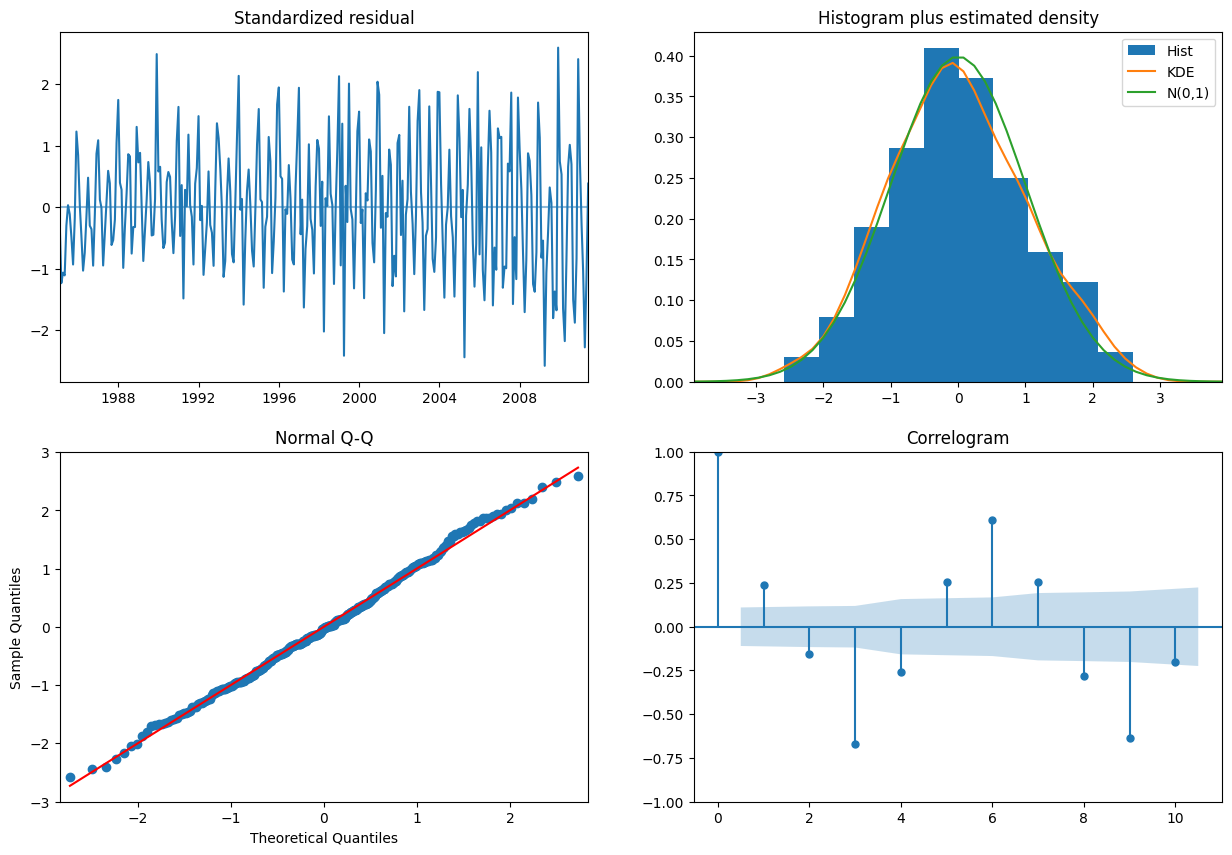

In [ ]:
# Интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(15,10))
plt.show()

# <font color='#11a642' size='6'> Модель ARIMA
Построение и обучение модели ARIMA, используя p,d,q из полученного результата по auto_arima.

In [ ]:
# Обучение модели ARIMA, используя p,d,q из полученного результата по auto_arima
arima_model= ARIMA(train["IPG2211A2N"], order= (0,1,2))
arima_model_fit= arima_model.fit()

In [ ]:
# Тест на нормальность остатков
normaltest_res = normaltest(arima_model_fit.resid)
print(f"Тест на нормальность остатков: p-value = {normaltest_res.pvalue}")
# если p-value не менее 0.05 , это означает, что остатки нормально распределены

Тест на нормальность остатков: p-value = 3.846752453680553e-68


## <font color='#11a642' size='5'>Построение прогноза для тестового набора данных

In [ ]:
# Прогноз на test наборе данных
start= len(train)
end= len(train) + len(test) -1

pred= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

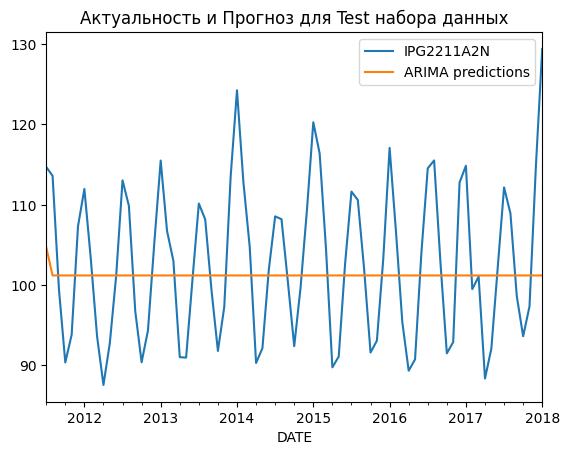

In [ ]:
# График прогноза
title= "Актуальность и Прогноз для Test набора данных"
test["IPG2211A2N"].plot(title= title, legend=True);
pred.plot(legend=True);

In [ ]:
# Построение модели AR (авторегрессия)
p=1
d=0
q=0
model_ar = ARIMA(train['IPG2211A2N'], order=(p,d,q))
results_ar_fit = model_ar.fit()

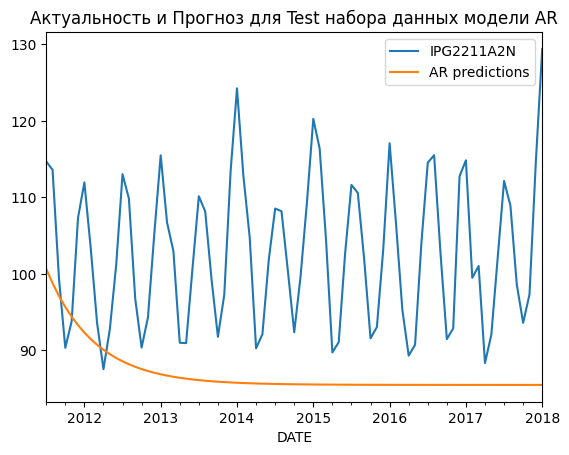

In [ ]:
# Прогноз модели AR
pred_results_ar = results_ar_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("AR predictions")

# График прогноза для модели AR
title= "Актуальность и Прогноз для Test набора данных модели AR"
test["IPG2211A2N"].plot(title= title, legend=True);
pred_results_ar.plot(legend=True);

## <font color='#11a642' size='5'>Оценка модели ARIMA

In [ ]:
# Оценка модели по штрафным баллам
mse_arima= mean_squared_error(test["IPG2211A2N"],pred)
rmse_arima = np.sqrt(mse_arima)

mse_ar = mean_squared_error(test["IPG2211A2N"], pred_results_ar)
rmse_ar = np.sqrt(mse_ar)

print(f"ARIMA RMSE = {rmse_arima}")
print(f"ARIMA MSE = {mse_arima} \n")
print(f"AR RMSE = {rmse_ar}")
print(f"AR MSE = {mse_ar}")

ARIMA RMSE = 9.691535360851763
ARIMA MSE = 93.92585765064011 

AR RMSE = 18.642766676911762
AR MSE = 347.5527493697716


Вывод (сравнение значений параметров):

Модель ARIMA(0,1,2) показывает лучшие результаты в прогнозировании временного ряда по сравнению с моделью AR.

Меньшие значения RMSE и MSE указывают на более точные прогнозы, что делает ARIMA предпочтительной для использования в данной задаче по сравнению с AR.

# <font color='#11a642' size='6'> Модель SARIMA
Построение и обучение модели SARIMA, используя p,d,q и P, D, Q для сезонности из полученного результата по auto_arima

In [ ]:
# найдем порядок p,d,q
# ARIMA: обучение модели с сезонной составляющей
smodel = auto_arima(train["IPG2211A2N"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1498.368, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1566.914, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1417.342, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1393.274, Time=1.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1635.302, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1474.424, Time=0.61 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1394.596, Time=1.72 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1394.370, Time=2.06 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1426.632, Time=0.88 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1395.497, Time=3.61 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1372.546, Time=0.71 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1467.241, Time=0.22 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1374.112, Time=0.98 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1373.892, Time=1.70 sec
 ARIMA(1,0,1)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  318
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -681.287
Date:                              Thu, 12 Sep 2024   AIC                           1370.574
Time:                                      11:30:10   BIC                           1385.468
Sample:                                  01-01-1985   HQIC                          1376.530
                                       - 06-01-2011                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6385      0.082      7.822      0.000       0.479       0.798
ar.L1          0.6022      0.042     14.333      0.000       0.520       0.684
ma.S.L12      -0.6695      0.047    -14.121      0.000      -0.762      -0.577
sigma2         4.9047      0.295     16.612      0.000       4.326       5.483
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                53.08
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.54   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# обучение модели
sarima_model= SARIMAX(train["IPG2211A2N"], order= (1,0,0), seasonal_order= (0,1,1,12))
sarima_model_fit= sarima_model.fit()

## <font color='#11a642' size='5'>Построение прогноза для тестового набора данных

In [ ]:
# Пронозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

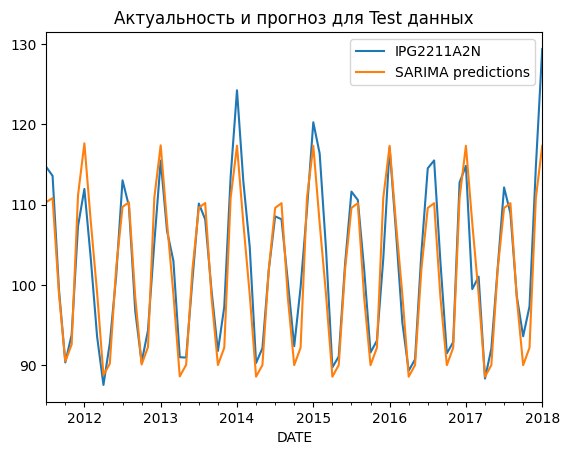

In [ ]:
# Построение прогноза
title= "Актуальность и прогноз для Test данных"
test["IPG2211A2N"].plot(title= title, legend=True)
pred.plot(legend=True);

## <font color='#11a642' size='5'>Оценка модели SARIMA

In [ ]:
# Оценка модели
mse_sarima = mean_squared_error(test["IPG2211A2N"],pred)
rmse_sarima = np.sqrt(mse_sarima)

print(f"SARIMA RMSE = {rmse_sarima}")
print(f"SARIMA MSE = {mse_sarima}")

SARIMA RMSE = 3.6140483022012804
SARIMA MSE = 13.061345130643957


Вывод (сравнение значений параметров):

p=1 (авторегрессия): модель использует один предыдущий лаг временного ряда для предсказания текущего значения. Это говорит о том, что в данных есть некоторая зависимость от предыдущих значений.

d=0 (разности): указывает на то, что ряд уже был приведён к стационарности, и теперь его можно моделировать без дополнительных разностей.

q=0 (скользящее среднее): прошлые ошибки не играют значимой роли в предсказании текущих значений, хотя сезонная составляющая включает MA-параметр.

P=0 (сезонная авторегрессия): на сезонном уровне нет значимой зависимости между текущим значением и предыдущими сезонными лагами.

D=1 (сезонные разности): Модель использует одну сезонную разность, что подразумевает наличие сезонности в данных, например, годовые изменения.

Q=1 (сезонное скользящее среднее): ошибка предыдущего года (лаг в 12 периодов) влияет на текущее значение ряда. Это важный сезонный эффект, который корректирует прогноз с учётом сезонных колебаний.

Общий вывод:

Модель SARIMA, судя по MSE и RMSE, показывает гораздо более точные результаты прогнозирования для временного ряда по сравнению с моделями ARIMA и AR.